In [4]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os
import sys

In [5]:
channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray TRANS diode to PRIME Keysight (channel 1)
channel_PIPS_fluo = "SARES11-GES1:CH2_VAL_GET/data"            #X-ray FLUO diode to PRIME Keysight (channel 2)
channel_Izero2 = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)

channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2
channel_PALM_drift = "SAROP11-PALMK118:CH2_VAL_GET/data"               #PALM drift

channel_laser_yaw= "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"



In [6]:
# only through raw and JF

channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_waveplate= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
channel_laser_yaw= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????

In [46]:
def LoadData_YAG(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = pulse_ids%4 == 0  
        reprate_laser = ((pulse_ids%2 == 0) & (pulse_ids%4 != 0))           #This is for 50 Hz 
    
        LaserDiode_pumped = BS_file[channel_LaserDiode][:][reprate_FEL]
        LaserDiode_unpumped = BS_file[channel_LaserDiode][:][reprate_laser]
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpumped = BS_file[channel_Izero][:][reprate_FEL]
        PIPS = BS_file[channel_PIPS_trans][:][reprate_FEL]
        LaserRefDiode = BS_file[channel_Laser_refDiode][:][reprate_laser]
        Delay = BS_file[channel_delay][:][reprate_laser]
        #Delay = BS_file[channel_laser_pitch][:][reprate_laser]

        
    return LaserDiode_pumped, LaserDiode_unpumped, Izero_pump, Izero_unpumped, PIPS, LaserRefDiode, Delay

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

In [59]:
scan_name ="Febpy_YAG_jet_time_zero_mono_350nm_015"
#scan_name ="Overlap_pitch_ref_008"

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
#DIR = "/sf/alvra/data/p17803/res/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [60]:
!ls -lah -rt $DIR

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 8.0G
-rw-r--r--.   1 root p17803 2.7G Jan 31 22:55 Febpy_YAG_jet_time_zero_mono_350nm_015_step0000.JF02T09V01.h5
drwxrwsr-x. 159 root p17803  32K Jan 31 22:55 ..
-rw-r--r--.   1 root p17803 2.7G Jan 31 22:55 Febpy_YAG_jet_time_zero_mono_350nm_015_step0001.JF02T09V01.h5
-rw-r--r--.   1 root p17803 1.1M Jan 31 22:55 Febpy_YAG_jet_time_zero_mono_350nm_015_step0000.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 2.7G Jan 31 22:55 Febpy_YAG_jet_time_zero_mono_350nm_015_step0002.JF02T09V01.h5
drwxr-sr-x.   2 root p17803 4.0K Jan 31 22:55 .
ra-c-031.psi.ch
There are 4 files in the folder /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350nm_015/


In [78]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 1

print ("Processing",numFiles,"files")

Laser_pumped = []
err_laser_pumped = []
Laser_unpumped = []
err_laser_unpumped = [] 
Izero_pumped = []
err_Izero_pumped = []
Izero_unpumped = []
err_Izero_unpumped = []
PIPS = []
Laser_ref = []
Delay_mm = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)
    if exists:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (Laser_pumped_loop,Laser_unpumped_loop,Izero_pumped_loop,Izero_unpumped_loop,PIPS_loop,Laser_ref_loop,delay_loop) = LoadData_YAG(str(data['scan_files'][i][0]))
        Laser_pumped.append(Laser_pumped_loop.mean())
        err_laser_pumped.append(Laser_pumped_loop.std()/np.sqrt(Laser_pumped_loop.size))
        Laser_unpumped.append(Laser_unpumped_loop.mean())
        err_laser_unpumped.append(Laser_unpumped_loop.std()/np.sqrt(Laser_unpumped_loop.size))
        Izero_pumped.append(Izero_pumped_loop.mean())
        err_Izero_pumped.append(Izero_pumped_loop.std()/np.sqrt(Izero_pumped_loop.size))
        Izero_unpumped.append(Izero_unpumped_loop.mean())
        err_Izero_unpumped.append(Izero_unpumped_loop.std()/np.sqrt(Izero_unpumped_loop.size))
        PIPS.append(PIPS_loop.mean())
        Laser_ref.append(Laser_ref_loop.mean())
        Delay_mm.append(delay_loop.mean())
    
Laser_pumped = np.asarray(Laser_pumped)
err_laser_pumped = np.asarray(err_laser_pumped)
Laser_unpumped = np.asarray(Laser_unpumped)
err_laser_unpumped = np.asarray(err_laser_unpumped)
Izero_pumped = np.asarray(Izero_pumped)
err_Izero_pumped = np.asarray(err_Izero_pumped)
Izero_unpumped = np.asarray(Izero_unpumped)
err_Izero_unpumped = np.asarray(err_Izero_unpumped)
Delay_mm = np.asarray(Delay_mm)

/sf/alvra/data/p17803/res/scan_info/Febpy_YAG_jet_time_zero_mono_350nm_015_scan_info.json
Processing 20 files
step 1 of 20 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350nm_015/Febpy_YAG_jet_time_zero_mono_350nm_015_step0000.BSREAD.h5
step 2 of 20 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350nm_015/Febpy_YAG_jet_time_zero_mono_350nm_015_step0001.BSREAD.h5
step 3 of 20 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350nm_015/Febpy_YAG_jet_time_zero_mono_350nm_015_step0002.BSREAD.h5
step 4 of 20 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350nm_015/Febpy_YAG_jet_time_zero_mono_350nm_015_step0003.BSREAD.h5
step 5 of 20 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350nm_015/Febpy_YAG_jet_time_zero_mono_350nm_015_step0004.BSREAD.h5
step 6 of 20 : Processing /sf/alvra/data/p17803/raw/scan_data/Febpy_YAG_jet_time_zero_mono_350n

299


<IPython.core.display.Javascript object>


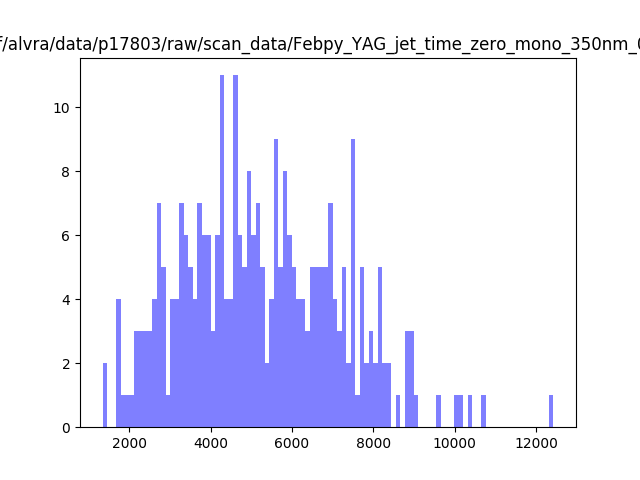

In [70]:
num_bins = 100
print (Izero_pumped_loop.size)
plt.figure()
plt.hist(Izero_pumped_loop, num_bins, facecolor='blue', alpha=0.5)
#plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
plt.title(DIR)


plt.show()

In [20]:
Izero_pumped

array([ 487.8322942 ,  504.532843  ,  516.33557944,  485.14626308,
        516.66059406,  528.04293635,  509.4348628 ,  521.96429986,
        525.95481377,  517.64491466,  522.01086091,  442.52611598,
        502.13501933,  513.64537482,  483.81407449,  508.59749929,
        491.13438567,  499.1042546 ,  524.49141914,  491.95653937,
        515.40570674])

In [12]:
Izero_unpumped[0:10]

array([5450.28128713, 5333.35953795, 5480.58033003, 5478.95158416,
       5156.569967  , 5496.53514851, 5634.07178218, 5425.819967  ,
       5346.34118812, 5400.13970297])

In [79]:
laser_pumped_norm = Laser_pumped / Izero_pumped
err_laser_pumped_norm = err_laser_pumped / Izero_pumped
laser_unpumped_norm = Laser_unpumped / Izero_unpumped
err_laser_unpumped_norm = err_laser_unpumped / Izero_unpumped

#without Izero
#laser_pumped_norm = Laser_pumped 
#err_laser_pumped_norm = err_laser_pumped 
#laser_unpumped_norm = Laser_unpumped 
#err_laser_unpumped_norm = err_laser_unpumped

laser_diff = -np.log10(laser_pumped_norm / laser_unpumped_norm)
#laser_diff = laser_pumped / Laser_unpumped # * (Izero_pumped / Izero_global) 
Delay_ps = (Delay_mm - 149.892)*3.333   # factor of 2 in delay due to the delay stage is considered below.
# here to add the time zero value

<IPython.core.display.Javascript object>


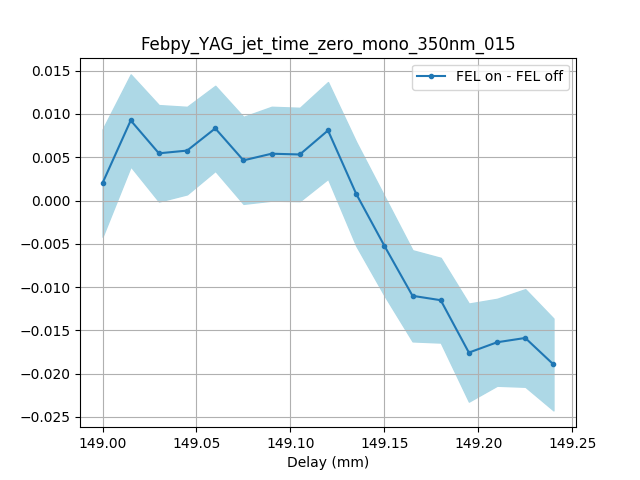

In [80]:
# Plot pump probe signal as a function of delay (stage mm)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot(Delay_mm, laser_diff, label="FEL on - FEL off",marker='.')
low_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) - (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
high_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) + (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')
plt.title(scan_name)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')

<IPython.core.display.Javascript object>


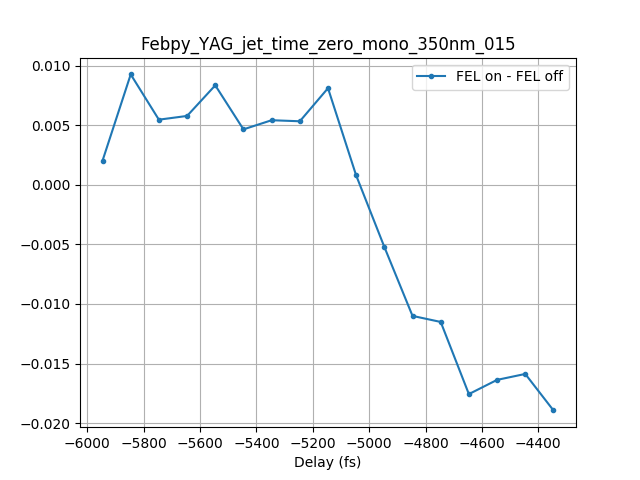

In [81]:
# Plot pump probe signal as a function of time (fs)

#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure()
plt.plot((2*Delay_ps)*1000, laser_diff, label="FEL on - FEL off",marker='.')

#low_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) - (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
#high_err= (-np.log10(laser_pumped_norm / laser_unpumped_norm) ) + (np.sqrt((err_laser_pumped_norm/laser_pumped_norm)**2+(err_laser_unpumped_norm/laser_unpumped_norm)**2))
#plt.fill_between(np.squeeze((2*Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title(scan_name)
plt.xlabel("Delay (fs)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

In [82]:
#MUST RUN THIS FOR FIT TO WORK!!!

Delay_mm_11 = Delay_mm.copy()
Delay_ps_11 = Delay_ps.copy()
laser_diff_11 = laser_diff.copy()

In [83]:
# Now fit with error funciton (defined above
parameters,extras = curve_fit(errfunc, Delay_mm_11, laser_diff_11, p0 = [0.05, 1, 149.0, -0.5])

print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
print("Width =",np.abs(np.round(parameters[3],3)),"mm")

Position t0 = 149.153 mm
Width = 0.026 mm


<IPython.core.display.Javascript object>


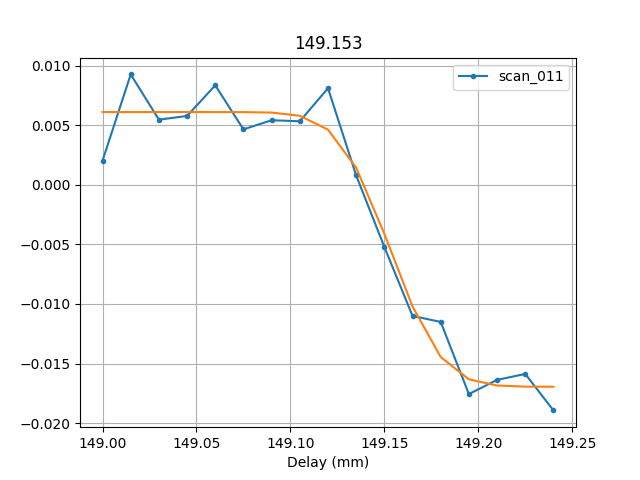

In [84]:
#... and the plot with the fit curve

#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_mm_11, laser_diff_11, label="scan_011",marker='.')
#plt.plot(Delay_mm_46, laser_diff_46, label="scan_046",marker='.')
#plt.plot(Delay_mm_50, laser_diff_50, label="scan_050",marker='.')
#plt.plot(Delay_mm, laser_diff, label="scan_049",marker='.')
plt.plot(Delay_mm_11, errfunc(Delay_mm_11,*parameters))

#low_err= signal_norm - err_signal_norm
#high_err= signal_norm + err_signal_norm

#plt.fill_between(position, low_err, high_err, color='lightblue')
plt.title(np.round(parameters[2], 3) )
plt.grid()
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

## Next cell  just to calculate time zero 

In [58]:
time_zero = 149.159       #this is in mm from the delay scans

desidered_delay = 0.5
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the
#delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

To be at 0.5 ps, put the laser pump delay stage to 149.2341 mm


In [74]:
(2*333/100)*(149.159-149.344)

-1.232100000000015